## 1. PROBLEM STATEMENT

Many financial institutions face significant losses from fraudulent credit card transactions, while overly aggressive fraud detection systems can disrupt legitimate customer activity. 
The goal of this project is to develop a predictive classification model to identify high-risk credit card transactions, enabling fraud teams to prioritize interventions while balancing fraud loss and customer experience.
Key Business Questions Answered include:
1. How effectively can we identify fraudulent transactions early while minimizing unnecessary customer disruptions?
2. In what scenarios should this model be relied upon, and when should human review be preferred?
3. What proportion of fraudulent transactions can the model detect at acceptable false-positive levels?
4. Does the transaction amount influence the likelihood of fraud, and can we use amount thresholds to prioritize investigation?



## 2. BUSINESS UNDERSTANDING

- The primary stakeholder for this project is the fraud prevention team at a credit card company. Their goal is to identify fraudulent transactions as quickly as possible so they can be blocked or reviewed before causing financial loss.

- In fraud detection, the cost of missing a fraudulent transaction is much higher than incorrectly flagging a legitimate one. Because of this, the business prioritizes recall, which measures how well the model identifies actual fraud, rather than overall accuracy.

- The model developed in this project is intended to support decision-making, not replace human judgment. Transactions flagged as high risk can be reviewed by analysts or combined with existing fraud detection rules, especially in real-time transaction monitoring systems.

## 3. DATA UNDERSTANDING



- This is a Kaggle dataset named Credit Card Fraud Detection.
- This dataset contains 10,000 credit card transactions with 9 features including the target "is_fraud" where 0  represents legitimate while 1 represent fraud. Numeric features include "amount", "transaction_hour", "device_trust_score", "velocity_last_24h" (transactions per day), and "cardholder_age". Binary flags are "foreign_transaction" and "location_mismatch". The categorical "merchant_category" covers Electronics, Grocery, Food, Travel, and Clothing. The transaction_id column serves only as an identifier and is not used for modeling.



## 4. DATA PREPARATION

In [58]:
#importing relevant libraries
#loading the dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier




df = pd.read_csv('credit_card_fraud_10k.csv')
df

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0
...,...,...,...,...,...,...,...,...,...,...
9995,9996,350.91,22,Food,0,0,99,4,37,0
9996,9997,410.04,5,Clothing,0,0,70,3,25,0
9997,9998,527.75,21,Electronics,0,0,44,2,45,0
9998,9999,91.20,2,Electronics,0,0,38,0,37,0


In [32]:
#understanding the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       10000 non-null  int64  
 1   amount               10000 non-null  float64
 2   transaction_hour     10000 non-null  int64  
 3   merchant_category    10000 non-null  object 
 4   foreign_transaction  10000 non-null  int64  
 5   location_mismatch    10000 non-null  int64  
 6   device_trust_score   10000 non-null  int64  
 7   velocity_last_24h    10000 non-null  int64  
 8   cardholder_age       10000 non-null  int64  
 9   is_fraud             10000 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [33]:
df.describe()

,transaction_id,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,175.949849,11.593300,0.097800,0.085700,61.798900,2.008900,43.468700,0.015100
std,2886.89568,175.392827,6.922708,0.297059,0.279935,21.487053,1.432559,14.979147,0.121957
min,1.00000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,18.000000,0.000000
25%,2500.75000,50.905000,6.000000,0.000000,0.000000,43.000000,1.000000,30.000000,0.000000
50%,5000.50000,122.095000,12.000000,0.000000,0.000000,62.000000,2.000000,44.000000,0.000000
75%,7500.25000,242.480000,18.000000,0.000000,0.000000,80.000000,3.000000,56.000000,0.000000
max,10000.00000,1471.040000,23.000000,1.000000,1.000000,99.000000,9.000000,69.000000,1.000000


In [34]:
#checking for missing values
df.isnull().sum()

transaction_id         0
amount                 0
transaction_hour       0
merchant_category      0
foreign_transaction    0
location_mismatch      0
device_trust_score     0
velocity_last_24h      0
cardholder_age         0
is_fraud               0
dtype: int64

Now that there are no missing values, we can drop duplicates incase there are any:

In [35]:
#drop duplicates
df = df.drop_duplicates()


We can now go ahead and understand our classification target:

In [36]:
#checking my classifictation target
df['is_fraud'].value_counts()

0    9849
1     151
Name: is_fraud, dtype: int64

This shows that fraudulent transactions are much less common than legitimate ones.

## 5. EXPLORATORY DATA ANALYSIS

## 5.1 Class Imbalance in Fraud Detection

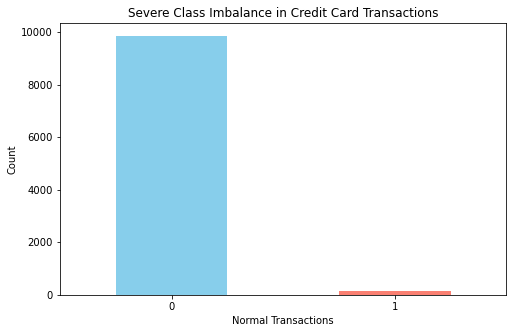

In [37]:
# Target distribution plot
plt.figure(figsize=(8,5))
df['is_fraud'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title('Severe Class Imbalance in Credit Card Transactions')
plt.ylabel('Count')
plt.xlabel('Normal Transactions')
plt.xticks(rotation=0)
plt.show()


From the above, Fraudulent transactions represent a very small fraction of total transactions, demonstrating severe class imbalance. This makes accuracy an unreliable evaluation metric, as a model predicting all transactions as legitimate would still achieve high accuracy while failing to detect fraud.

## 5.2 Distribution of Transaction Amounts

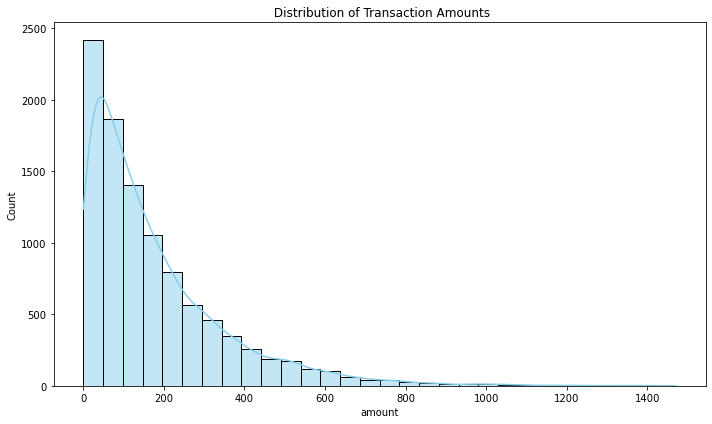

In [38]:
def show_fig():
    plt.tight_layout()
    plt.show()


fig = plt.figure(figsize=(10,6))
sns.histplot(df['amount'], bins=30, kde=True, color='skyblue')
plt.title(f' Distribution of Transaction Amounts')
show_fig()


From this visualization, Transaction amounts are heavily right-skewed, with most transactions occurring at lower values and a long tail of high-value transactions. This suggests that unusually large transactions may carry elevated fraud risk and supports scaling the amount feature during preprocessing.

## 5.3 Fraud Distribution Across Merchant Categories

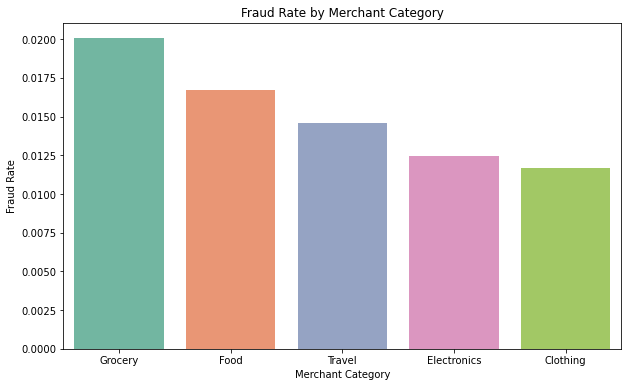

In [39]:
fraud_rate = (
    df.groupby('merchant_category')['is_fraud']
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette='Set2')
plt.title('Fraud Rate by Merchant Category')
plt.ylabel('Fraud Rate')
plt.xlabel('Merchant Category')
plt.show()


Some categories exhibit higher fraud rates, indicating opportunities for category-specific risk controls and targeted monitoring.
Let's now look at correlation with target variable;

Top 10 features correlated with fraud:
is_fraud               1.000000
foreign_transaction    0.185597
location_mismatch      0.173009
velocity_last_24h      0.103413
amount                 0.028404
cardholder_age        -0.000590
transaction_id        -0.010155
device_trust_score    -0.137913
transaction_hour      -0.138665
Name: is_fraud, dtype: float64


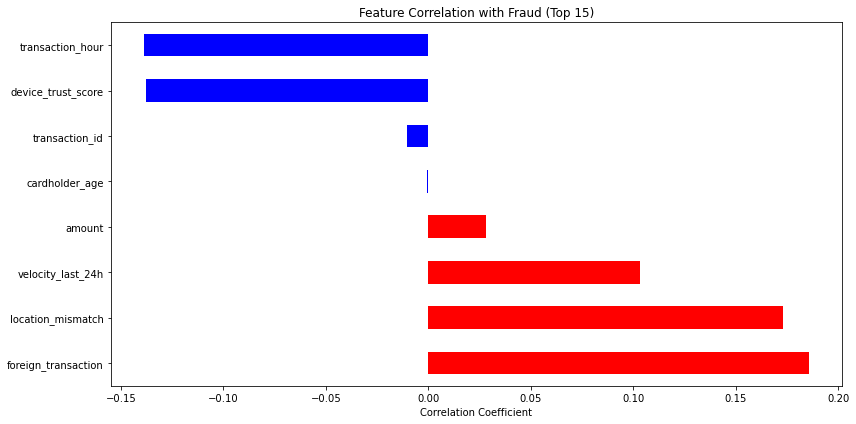

In [40]:
# Correlation analysis with target (numeric columns only)
numeric_df = df.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['is_fraud'].sort_values(ascending=False)
print("Top 10 features correlated with fraud:")
print(correlations.head(10))

plt.figure(figsize=(12, 6))
correlations[1:16].plot(kind='barh', color=['red' if x > 0 else 'blue' for x in correlations[1:16]])
plt.title('Feature Correlation with Fraud (Top 15)')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

## 6. FEATURE ENGINEERING

## Separate Features and Target

In [41]:
#dropping Transaction_id(identifier)
#defining predictors and target
X = df.drop(columns=["is_fraud", "transaction_id"])
y = df["is_fraud"]

In [42]:
#column types
numeric_features = [
    "amount",
    "transaction_hour",
    "foreign_transaction",
    "location_mismatch",
    "device_trust_score",
    "velocity_last_24h",
    "cardholder_age"
]

categorical_features = ["merchant_category"]


## Train–Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_train.shape

X_test.shape

(2000, 8)

## Preprocessing

In [44]:
#scaling numeric features
#One-hot encode merchant categories
#avoiding multicollinearity

categorical_features = ["merchant_category"]

# Preprocessing
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    
    handle_unknown="ignore"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)



## Classification Metrics Justification

Credit card fraud detection presents a severe class imbalance, where fraudulent transactions represent a very small proportion of total transactions. As a result, accuracy is not an appropriate primary evaluation metric, as a model predicting all transactions as legitimate would still achieve high accuracy while failing to detect fraud.

This project prioritizes recall, which measures the proportion of fraudulent transactions correctly identified, to minimize missed fraud. ROC-AUC is also used to evaluate the model’s ability to discriminate between fraudulent and legitimate transactions across different probability thresholds.


## 7. MODELING AND EVALUATION

## 7.1 Baseline Model: Logistic Regression

##     Building and training model

In [45]:

log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

log_reg_model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'transaction_hour',
                                                   'foreign_transaction',
                                                   'location_mismatch',
                                                   'device_trust_score',
                                                   'velocity_last_24h',
                                                   'cardholder_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant_category'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## Predictions and Accuracy

In [46]:
y_pred_lr = log_reg_model.predict(X_test)
y_prob_lr = log_reg_model.predict_proba(X_test)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

Logistic Regression Accuracy: 0.9585


## Confusion Matrix

In [47]:
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr))


Confusion Matrix (Logistic Regression):
[[1887   83]
 [   0   30]]


## Classification Report

In [48]:
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1970
           1       0.27      1.00      0.42        30

    accuracy                           0.96      2000
   macro avg       0.63      0.98      0.70      2000
weighted avg       0.99      0.96      0.97      2000



## ROC-AUC

In [49]:
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("ROC-AUC (Logistic Regression):", roc_auc_lr)


ROC-AUC (Logistic Regression): 0.9932994923857867


## ROC Curve

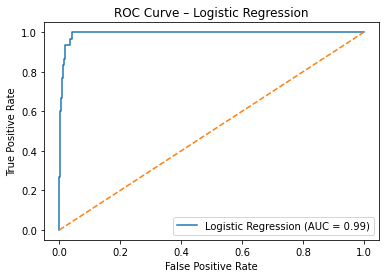

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()


## 7.2 Refined Model: Decision Tree Classifier

## Building and Training Model

In [51]:
dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        max_depth=5,
        class_weight="balanced",
        random_state=42
    ))
])

dt_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'transaction_hour',
                                                   'foreign_transaction',
                                                   'location_mismatch',
                                                   'device_trust_score',
                                                   'velocity_last_24h',
                                                   'cardholder_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant_category'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

## Predictions and Accuracy

In [52]:
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")


Decision Tree Accuracy: 0.9670


## confusion Matrix

In [53]:
print("Confusion Matrix (Decision Tree):")
print(confusion_matrix(y_test, y_pred_dt))


Confusion Matrix (Decision Tree):
[[1904   66]
 [   0   30]]


## Classification Report

In [54]:
print("Classification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))


Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1970
           1       0.31      1.00      0.48        30

    accuracy                           0.97      2000
   macro avg       0.66      0.98      0.73      2000
weighted avg       0.99      0.97      0.98      2000



## ROC-AUC

In [55]:
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
print("ROC-AUC (Decision Tree):", roc_auc_dt)


ROC-AUC (Decision Tree): 0.9999746192893402


## ROC Curve

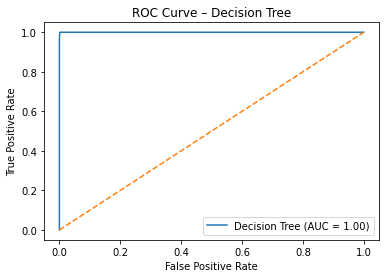

In [56]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.show()



Modeling followed an iterative approach. A Logistic Regression model was used as a baseline due to its interpretability. A Decision Tree model with constrained depth was then introduced to capture non-linear relationships while reducing the risk of overfitting. The Decision Tree model was selected as the final model based on its improved recall and ROC-AUC performance.


## 7.3 Model Performance Comparison

In [57]:
summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Fraud)", "Recall (Fraud)", "F1-Score (Fraud)", "ROC-AUC"],
    "Logistic Regression": [
        accuracy_lr,
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["precision"],
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["f1-score"],
        roc_auc_lr
    ],
    "Decision Tree": [
        accuracy_dt,
        classification_report(y_test, y_pred_dt, output_dict=True)["1"]["precision"],
        classification_report(y_test, y_pred_dt, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_dt, output_dict=True)["1"]["f1-score"],
        roc_auc_dt
    ]
}).round(3)

summary_df


,Metric,Logistic Regression,Decision Tree
0,Accuracy,0.958,0.967
1,Precision (Fraud),0.265,0.312
2,Recall (Fraud),1.000,1.000
3,F1-Score (Fraud),0.420,0.476
4,ROC-AUC,0.993,1.000


## 8. Predictive Findings

The tuned Decision Tree model outperformed the baseline Logistic Regression across ROC-AUC and recall metrics. The unusually high ROC-AUC values suggest strong feature separability in this dataset and should be interpreted cautiously when considering real-world deployment, where fraud patterns may be more complex.


## 9. BUSINESS RECOMMENDATIONS

The model is most useful in real-time transaction screening scenarios where immediate action can be taken. It is less appropriate for historical auditing where latency is not a concern. 
The business can use predicted fraud probabilities to flag the top 1–2% of transactions for review or additional authentication. Adjusting transaction thresholds during high-risk periods may further reduce fraud losses.

Merchant categories with elevated fraud rates may warrant stricter authentication or lower approval thresholds, particularly for high-value or foreign transactions.

Thresholds can be adjusted dynamically based on operational capacity, allowing fraud teams to balance investigation workload with fraud risk exposure.


## 10. SUMMARY

The tuned Decision Tree model was selected as the final model due to its superior ROC-AUC and recall performance compared to the baseline Logistic Regression. This indicates a stronger ability to identify fraudulent transactions while maintaining generalization to unseen data.

Correlation and model behavior suggest that fraud detection is driven by a small number of high-impact variables, supporting confidence in the model’s stability. While false positives remain a concern, the model provides a strong foundation for risk-based transaction screening.

Future improvements could include ensemble methods, threshold optimization, and more frequent retraining to adapt to evolving fraud patterns.